In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Getting the data

In [93]:
cars = pd.read_excel('cars.xlsx')
cars.head(5)

,num_id,brand,model,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,seatsAmount,ind_sold
0,10006776,Mercedes,C220,59.0,45000.00,65.22,1388.44,32.41,69000.000000,0,0,0,0,5,0
1,10008526,Mercedes,V220,46.0,156000.00,60.00,3052.32,51.11,260000.000000,1,0,1,0,7,1
2,10008996,Mitsubishi,L200,37.0,146069.00,81.03,3023.54,48.31,180256.512821,0,1,1,1,5,0
3,10013906,Hyundai,Tucson,34.0,113161.52,79.81,1874.57,60.37,141795.017094,1,1,0,1,5,1
4,10021356,Hyundai,I-20,29.0,76402.79,84.82,1380.31,55.35,90078.034188,0,1,0,0,5,1


In [94]:
# create a dataframe with the variables we want to use for the model (without brand and model)

X = cars.iloc[:, 1:-1]
X.drop(['model','brand'], axis=1, inplace=True)
y = cars.iloc[:, -1]

In [95]:
# scaling numerical data 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X = pd.merge(left=scaled_df,
             right=X.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X.head(5)

,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,seatsAmount
0,1.232796,-0.895359,-0.264811,-0.627607,-0.918512,-0.904007,0,0,0,0,5
1,0.124112,0.147691,-0.597220,-0.104603,0.140178,0.369488,1,0,1,0,7
2,-0.643439,0.054371,0.741965,-0.113649,-0.018342,-0.162203,0,1,1,1,5
3,-0.899290,-0.254856,0.664276,-0.474803,0.664428,-0.418645,1,1,0,1,5
4,-1.325707,-0.600272,0.983312,-0.630162,0.380224,-0.763469,0,1,0,0,5


### Feature Selection

Feature selection using XGBClassifier

In [96]:
#using XGBClassifier to get feature importance
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X, y)
feat_importances_df = pd.DataFrame({'feature_importance': model.feature_importances_}, index=X.columns)
feat_importances_df = feat_importances_df.sort_values(by='feature_importance', ascending=False)
feat_importances_df.head(15)

c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,feature_importance
is_male,0.676281
isNew,0.094774
age,0.045297
car_price,0.031033
isSUV,0.026152
funding_amount,0.023800
month_payment,0.022369
payment_duration,0.021172
fundingPercent,0.020232
isWorkCar,0.019454


Splitting the data into train & test

In [97]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1338
           1       0.59      0.69      0.64       973

    accuracy                           0.67      2311
   macro avg       0.67      0.67      0.67      2311
weighted avg       0.68      0.67      0.67      2311

----------------------------------------------------------
[-2.41126469]
----------------------------------------------------------
is_male             1.939
isNew               0.725
car_price          -0.303
age                -0.234
funding_amount      0.154
fundingPercent     -0.101
isWorkCar           0.077
payment_duration    0.048
isSUV               0.039
month_payment      -0.014
seatsAmount        -0.004
dtype: float64


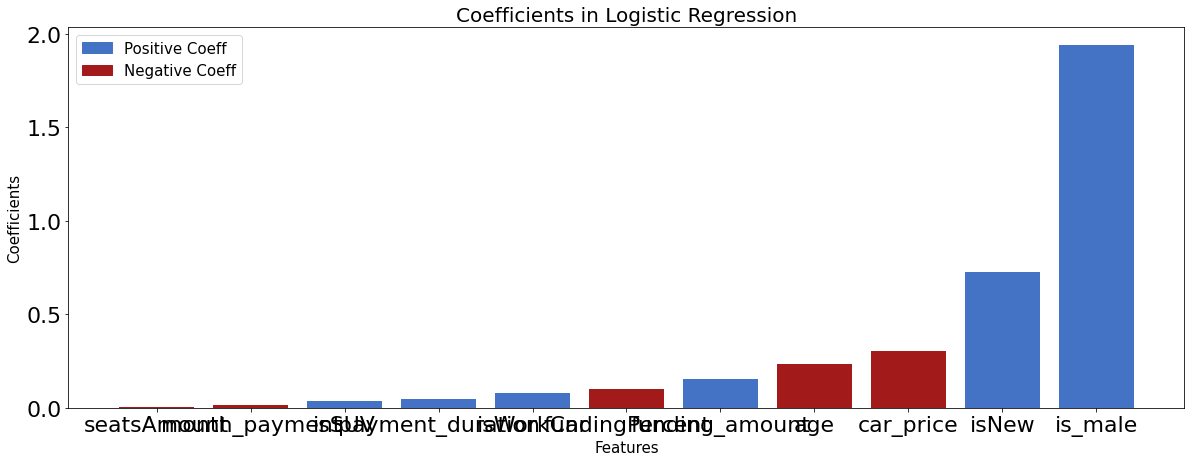

In [98]:


from sklearn.linear_model import LogisticRegression
import matplotlib.patches as mpatches

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
from sklearn.metrics import classification_report
print(classification_report(y_test, logreg.predict(X_test)))
print("----------------------------------------------------------")
#printing the coefficients of the model
print(logreg.intercept_)
print("----------------------------------------------------------")
# plotting the coefficients of the model

#merge the coefficients with the feature names
coefs = pd.Series(logreg.coef_[0], index=X_train.columns).apply(lambda x: round(x, 3))
#sort the feature names according to their coeeficients
abs_coefs = coefs.sort_values()
print(abs_coefs.reindex(abs_coefs.abs().sort_values().index)[::-1])
#sort by absolute value of coefficients
abs_coefs = coefs.abs().sort_values()
coefs_copy=abs_coefs.copy()
#set the values to  be equal to those of the original coefficients
coefs_copy[coefs_copy>0]=coefs[abs_coefs>0]
#plot the coefficients in descending order of absolute value of coefficients and negative values are plotted in red and positive in blue
plt.figure(figsize=(20, 7))
plt.bar(abs_coefs.index, abs_coefs.values, width=0.8, color=(coefs_copy > 0).map({True: '#4472c4', False: '#a31a1a'}))
#add the labels to the plot
plt.xlabel('Features', fontsize=15)
plt.ylabel('Coefficients', fontsize=15)
#add the title to the plot
plt.title('Coefficients in Logistic Regression', fontsize=20)
#add legend to the plot and set the location
blue_patch = mpatches.Patch(color='#4472c4', label='Positive Coeff')
red_patch = mpatches.Patch(color='#a31a1a', label='Negative Coeff')
plt.legend(handles=[blue_patch,red_patch],fontsize=15)

plt.show()

In [99]:
# create X with dummy variables and y (withouth removing any features from the model)

X = cars.iloc[:, 1:-1]
X = pd.get_dummies(X)
y = cars.iloc[:, -1]

In [100]:
#scale the data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X = pd.merge(left=scaled_df,
             right=X.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X.head(5)

,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,...,model_Tucson,model_V220,model_V250,model_Veloster,model_Viano,model_Vitara,model_Vito,model_X5,model_X6,model_XV
0,1.232796,-0.895359,-0.264811,-0.627607,-0.918512,-0.904007,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.124112,0.147691,-0.597220,-0.104603,0.140178,0.369488,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,-0.643439,0.054371,0.741965,-0.113649,-0.018342,-0.162203,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.899290,-0.254856,0.664276,-0.474803,0.664428,-0.418645,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0
4,-1.325707,-0.600272,0.983312,-0.630162,0.380224,-0.763469,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
#feature importance using XGBClassifier for the model with dummy variables
model = XGBClassifier()
model.fit(X, y)
feat_importances_df = pd.DataFrame({'feature_importance': model.feature_importances_}, index=X.columns)
feat_importances_df = feat_importances_df.sort_values(by='feature_importance', ascending=False)
feat_importances_df.head(15)

c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,feature_importance
is_male,0.330209
isNew,0.056174
age,0.022576
model_L200,0.014588
model_Tucson,0.014447
model_Eclipse,0.013857
car_price,0.013848
model_Outlander,0.013702
model_I-35,0.013294
model_I-20,0.013227


Running a Logisitic Regression model using the Backward Algorithm to determine which features we should keep

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

In [103]:
#Running a Logisitic Regression model using the Backward Algorithm to determine which features we should keep
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
accuracies = []

for feature in reversed(feat_importances_df.index.to_list()):
    logreg = LogisticRegression(max_iter=500)
    logreg.fit(X_train_copy, y_train)

    # calculate accuracy
    accuracy = logreg.score(X_test_copy, y_test)
    accuracies.append(accuracy)

    # drop feature from X_train
    X_train_copy = X_train_copy.drop([feature], axis=1)
    X_test_copy=X_test_copy.drop([feature], axis=1)

In [104]:
print(f"The best accuracy is {max(accuracies)}, using the first {len(feat_importances_df.index.to_list()) - accuracies.index(max(accuracies))} features (removing {accuracies.index(max(accuracies))} features) ")

The best accuracy is 0.6715707485936824, using the first 30 features (removing 282 features) 


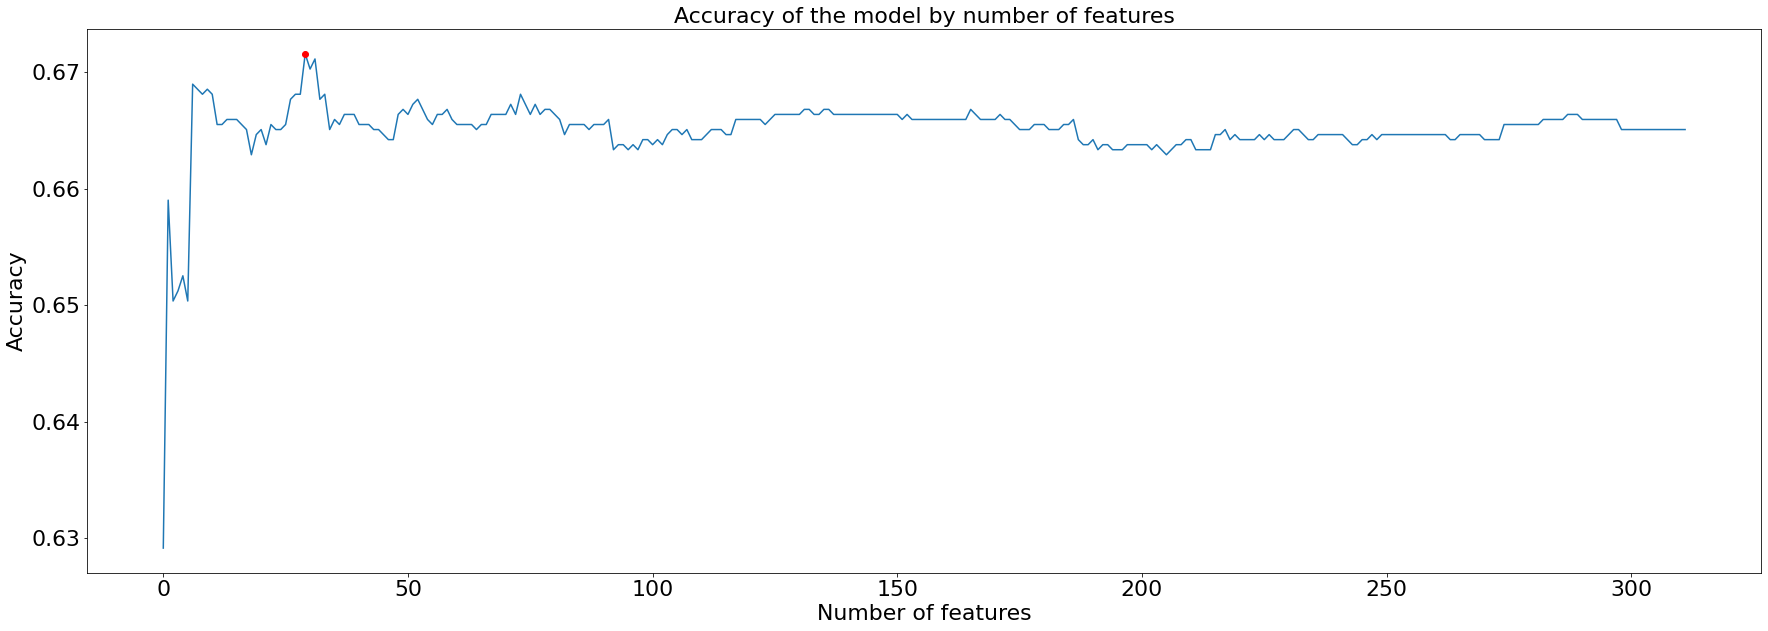

In [105]:
#plotting the accuracy of the model using the Backward Algorithm
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.titlesize': 'medium'})

plt.plot(accuracies[::-1])
plt.plot(accuracies[::-1].index(max(accuracies)), max(accuracies), 'ro')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy of the model by number of features')
plt.show()

Forward feature selection

In [106]:
#forward feature selection
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_features = []
accuracies_for = []
for feature in feat_importances_df.index.to_list():
    X_train_features.append(feature)
    #get the features from X_train
    X_train_copy = X_train[X_train_features]
    X_test_copy = X_test[X_train_features]

    logreg = LogisticRegression(max_iter=500)
    logreg.fit(X_train_copy, y_train)

    # calculate accuracy
    accuracy = logreg.score(X_test_copy, y_test)
    accuracies_for.append(accuracy)


In [107]:
print(f"The best accuracy is {max(accuracies_for)}, using the first {accuracies_for.index(max(accuracies_for))} features (removing {len(feat_importances_df.index.to_list()) - accuracies_for.index(max(accuracies_for))} features) ")

The best accuracy is 0.6715707485936824, using the first 29 features (removing 283 features) 


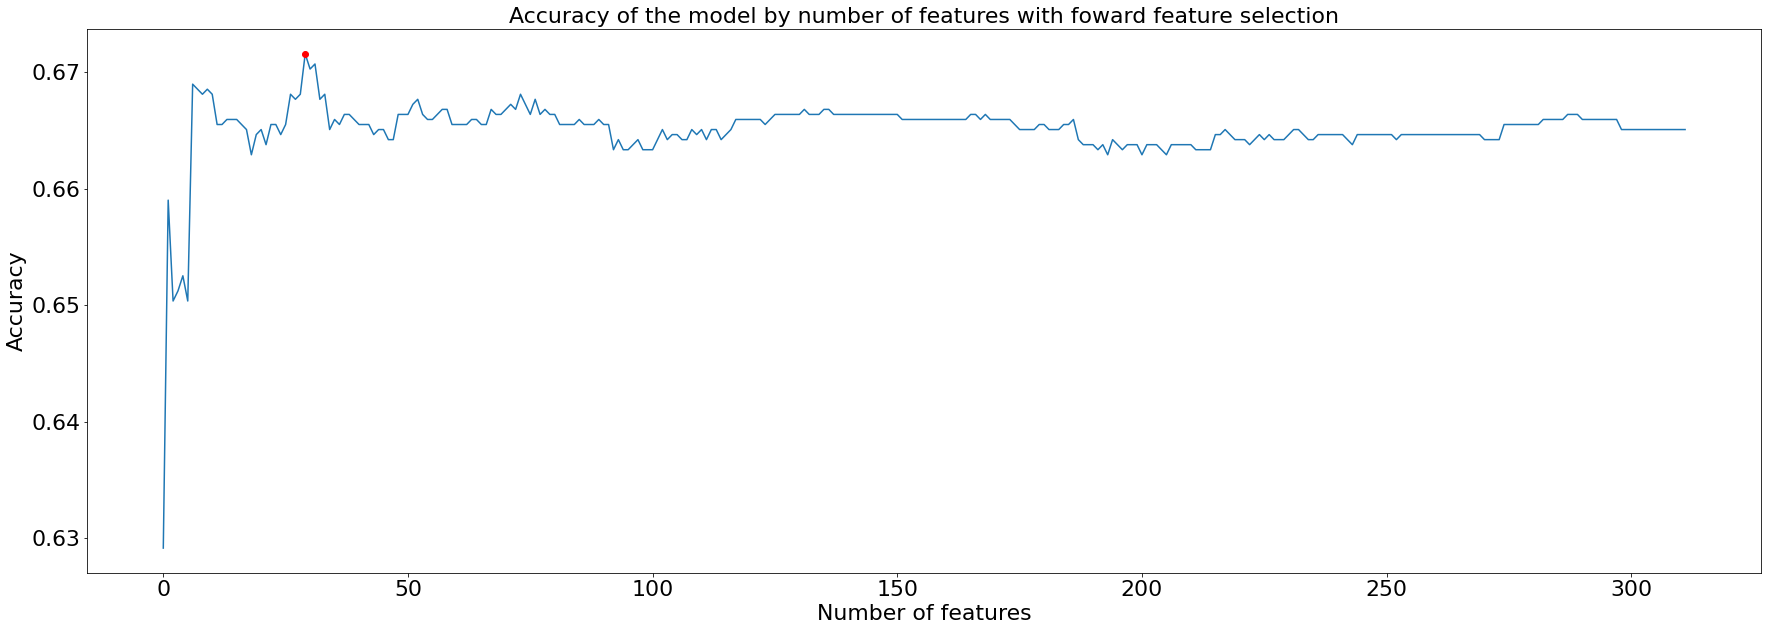

In [108]:
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.titlesize': 'medium'})

plt.plot(accuracies_for)
plt.plot(accuracies_for.index(max(accuracies_for)), max(accuracies_for), 'ro')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy of the model by number of features with foward feature selection')
plt.show()

Predict Test

In [111]:
# create X with dummy variables and y without brand only

X_without_brand = cars.iloc[:, 1:-1]
X_without_brand.drop(['brand'], axis=1, inplace=True)
X_without_brand = pd.get_dummies(X_without_brand)
y = cars.iloc[:, -1]

In [112]:
# scaling numerical data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_without_brand[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_without_brand = pd.merge(left=scaled_df,
             right=X_without_brand.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X_without_brand.head(5)

,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,...,model_Tucson,model_V220,model_V250,model_Veloster,model_Viano,model_Vitara,model_Vito,model_X5,model_X6,model_XV
0,1.232796,-0.895359,-0.264811,-0.627607,-0.918512,-0.904007,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.124112,0.147691,-0.597220,-0.104603,0.140178,0.369488,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,-0.643439,0.054371,0.741965,-0.113649,-0.018342,-0.162203,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.899290,-0.254856,0.664276,-0.474803,0.664428,-0.418645,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0
4,-1.325707,-0.600272,0.983312,-0.630162,0.380224,-0.763469,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
#logistic regression on X_without_brand

X_train, X_test, y_train, y_test = train_test_split(X_without_brand, y, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

In [114]:
#training the model

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [115]:
probability = logreg.predict_proba(X_test)
prediction = logreg.predict(X_test)

In [116]:
y_test_prob_0 = pd.Series(probability[:, 0], name='probability_0', index=y_test.index)
y_test_prob_1 = pd.Series(probability[:, 1], name='probability_1', index=y_test.index)
y_test_pred = pd.Series(prediction, name='prediction', index=y_test.index)

train_results = pd.DataFrame(data={
    'probability_0': y_test_prob_0,
    'probability_1': y_test_prob_1,
    'prediction': y_test_pred,
    'actual': y_test
})

train_results.head(5)

,probability_0,probability_1,prediction,actual
8958,0.833591,0.166409,0,0
7445,0.829673,0.170327,0,0
10007,0.897339,0.102661,0,0
11115,0.875761,0.124239,0,0
8501,0.440091,0.559909,1,1


In [117]:
#report for the logistic regression model without brand
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1338
           1       0.59      0.68      0.63       973

    accuracy                           0.66      2311
   macro avg       0.66      0.67      0.66      2311
weighted avg       0.67      0.66      0.67      2311



model with the most pouplers brands (97% of the data)

In [118]:
cars

,num_id,brand,model,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,seatsAmount,ind_sold
0,10006776,Mercedes,C220,59.0,45000.00,65.22,1388.44,32.41,69000.000000,0,0,0,0,5,0
1,10008526,Mercedes,V220,46.0,156000.00,60.00,3052.32,51.11,260000.000000,1,0,1,0,7,1
2,10008996,Mitsubishi,L200,37.0,146069.00,81.03,3023.54,48.31,180256.512821,0,1,1,1,5,0
3,10013906,Hyundai,Tucson,34.0,113161.52,79.81,1874.57,60.37,141795.017094,1,1,0,1,5,1
4,10021356,Hyundai,I-20,29.0,76402.79,84.82,1380.31,55.35,90078.034188,0,1,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11550,99957497,Mitsubishi,Pajero,42.0,198290.93,73.79,4700.10,42.19,268708.504274,1,1,0,1,5,0
11551,99958487,Mercedes,C220,47.0,127415.00,85.00,2349.21,54.24,149900.000000,0,1,0,0,5,0
11552,99982187,Hyundai,I-20,40.0,75493.24,80.00,1242.15,60.78,94368.606838,0,1,0,0,5,0
11553,99992866,Mitsubishi,Lancer,45.0,66619.68,65.49,819.49,81.29,101719.000000,1,1,0,0,5,0


In [119]:
#model with the 3 most popular brands in the dataset (there are 97% of the total offers)
top_selling_cars = cars
#get all rows that the brand  is 'Mercedes' , 'Hyundai' or 'Mitsubishi' 
top_selling_cars=top_selling_cars.loc[top_selling_cars['brand'].isin(['Mercedes', 'Hyundai', 'Mitsubishi'])]
top_selling_cars.reset_index(drop=True, inplace=True)
top_selling_cars


,num_id,brand,model,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,seatsAmount,ind_sold
0,10006776,Mercedes,C220,59.0,45000.00,65.22,1388.44,32.41,69000.000000,0,0,0,0,5,0
1,10008526,Mercedes,V220,46.0,156000.00,60.00,3052.32,51.11,260000.000000,1,0,1,0,7,1
2,10008996,Mitsubishi,L200,37.0,146069.00,81.03,3023.54,48.31,180256.512821,0,1,1,1,5,0
3,10013906,Hyundai,Tucson,34.0,113161.52,79.81,1874.57,60.37,141795.017094,1,1,0,1,5,1
4,10021356,Hyundai,I-20,29.0,76402.79,84.82,1380.31,55.35,90078.034188,0,1,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11201,99957497,Mitsubishi,Pajero,42.0,198290.93,73.79,4700.10,42.19,268708.504274,1,1,0,1,5,0
11202,99958487,Mercedes,C220,47.0,127415.00,85.00,2349.21,54.24,149900.000000,0,1,0,0,5,0
11203,99982187,Hyundai,I-20,40.0,75493.24,80.00,1242.15,60.78,94368.606838,0,1,0,0,5,0
11204,99992866,Mitsubishi,Lancer,45.0,66619.68,65.49,819.49,81.29,101719.000000,1,1,0,0,5,0


In [120]:
# create X with dummy variables and y
X_top_selling = top_selling_cars.iloc[:, 1:-1]
X_top_selling = pd.get_dummies(X_top_selling)
y = top_selling_cars.iloc[:, -1]

In [121]:
# scaling numerical data

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_top_selling[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_top_selling = pd.merge(left=scaled_df,
             right=X_top_selling.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X_top_selling.head(5)

,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,...,model_SLK55,model_Santa fe,model_Sonata,model_Space Star,model_Tucson,model_V220,model_V250,model_Veloster,model_Viano,model_Vito
0,1.223673,-0.907505,-0.271608,-0.628426,-0.931298,-0.913493,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.117113,0.149206,-0.604905,-0.102989,0.126894,0.372762,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.648968,0.054663,0.737858,-0.112077,-0.031551,-0.164256,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.904328,-0.258613,0.659961,-0.474911,0.650898,-0.423268,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
4,-1.329928,-0.608553,0.979849,-0.630993,0.366827,-0.771547,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_top_selling, y, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

In [123]:
#train logistic regression model

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)

In [124]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1314
           1       0.57      0.70      0.63       928

    accuracy                           0.65      2242
   macro avg       0.66      0.66      0.65      2242
weighted avg       0.67      0.65      0.66      2242



In [125]:
#model for top selling cars without brand feature 
X_top_selling_cars_without_brand= top_selling_cars.iloc[:, 1:-1]
X_top_selling_cars_without_brand.drop(['brand'], axis=1, inplace=True)
X_top_selling_cars_without_brand = pd.get_dummies(X_top_selling_cars_without_brand)
y = top_selling_cars.iloc[:, -1]

In [126]:
# scaling numerical data

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_top_selling_cars_without_brand[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_top_selling_cars_without_brand = pd.merge(left=scaled_df,
             right=X_top_selling_cars_without_brand.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X_top_selling_cars_without_brand.head(5)

,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,...,model_SLK55,model_Santa fe,model_Sonata,model_Space Star,model_Tucson,model_V220,model_V250,model_Veloster,model_Viano,model_Vito
0,1.223673,-0.907505,-0.271608,-0.628426,-0.931298,-0.913493,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.117113,0.149206,-0.604905,-0.102989,0.126894,0.372762,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.648968,0.054663,0.737858,-0.112077,-0.031551,-0.164256,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.904328,-0.258613,0.659961,-0.474911,0.650898,-0.423268,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
4,-1.329928,-0.608553,0.979849,-0.630993,0.366827,-0.771547,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
#split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X_top_selling_cars_without_brand, y, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

In [128]:
#train logistic regression model

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [129]:
probability = logreg.predict_proba(X_test)
prediction = logreg.predict(X_test)

In [130]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1314
           1       0.57      0.70      0.63       928

    accuracy                           0.65      2242
   macro avg       0.66      0.66      0.65      2242
weighted avg       0.67      0.65      0.66      2242



In [131]:
#tring to change the classes weigths to make the model more accurate and to see if it helped
accuracies=[]
for i in range(1, 10):
    for j in range(1,10):
        logreg = LogisticRegression(max_iter=500,class_weight={0:i*0.1,1:j*0.1})
        logreg.fit(X_train, y_train)
        probability = logreg.predict_proba(X_train)
        prediction = logreg.predict(X_train)
        accuracy = logreg.score(X_train, y_train)
        accuracies.append([i*0.1, j*0.1, accuracy])
#get the best accuracy
accuracies = pd.DataFrame(accuracies, columns=['class_weight_0', 'class_weight_1', 'accuracy'])

In [132]:
#print the classes weights and accuracy order by accuracy
accuracies.sort_values(by=['accuracy'], ascending=False, inplace=True)
accuracies

,class_weight_0,class_weight_1,accuracy
70,0.8,0.8,0.683623
80,0.9,0.9,0.683400
79,0.9,0.8,0.683400
60,0.7,0.7,0.683400
30,0.4,0.4,0.683400
...,...,...,...
4,0.1,0.5,0.563922
5,0.1,0.6,0.512606
6,0.1,0.7,0.480812
7,0.1,0.8,0.464079


In [133]:
#model when we play with the class weights menually
logreg = LogisticRegression(max_iter=500,class_weight={0:2, 1:2})
logreg.fit(X_train, y_train)
probability = logreg.predict_proba(X_test)
prediction = logreg.predict(X_test)
accuracy = logreg.score(X_test, y_test)
print(accuracy)

0.6547725245316681


In [134]:
#feature importance of the model
model = XGBClassifier()
model.fit(X_top_selling_cars_without_brand, y)
feat_importances_df = pd.DataFrame({'feature_importance': model.feature_importances_}, index=X_top_selling_cars_without_brand.columns)
feat_importances_df = feat_importances_df.sort_values(by='feature_importance', ascending=False)
feat_importances_df.head(15)

[20:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,feature_importance
is_male,0.357265
isNew,0.044140
model_E200,0.026393
age,0.022950
model_Attrage,0.013798
model_C200,0.013704
car_price,0.013527
model_Arocs 3240,0.013378
model_L200,0.013190
model_316,0.012950


In [135]:
#forward feature selection
X_train_copy = X_train.copy()
X_train_features = []
accuracies_for = []
for feature in feat_importances_df.index.to_list():
    X_train_features.append(feature)
    #get the features from X_train
    X_train_copy = X_train[X_train_features]

    logreg = LogisticRegression(max_iter=500)
    logreg.fit(X_train_copy, y_train)

    # calculate accuracy
    accuracy = logreg.score(X_train_copy, y_train)
    accuracies_for.append(accuracy)


In [136]:
print(f"The best accuracy is {max(accuracies_for)}, using the first {accuracies_for.index(max(accuracies_for))} features (removing {len(feat_importances_df.index.to_list()) - accuracies_for.index(max(accuracies_for))} features) ")

The best accuracy is 0.6836233824185631, using the first 151 features (removing 14 features) 


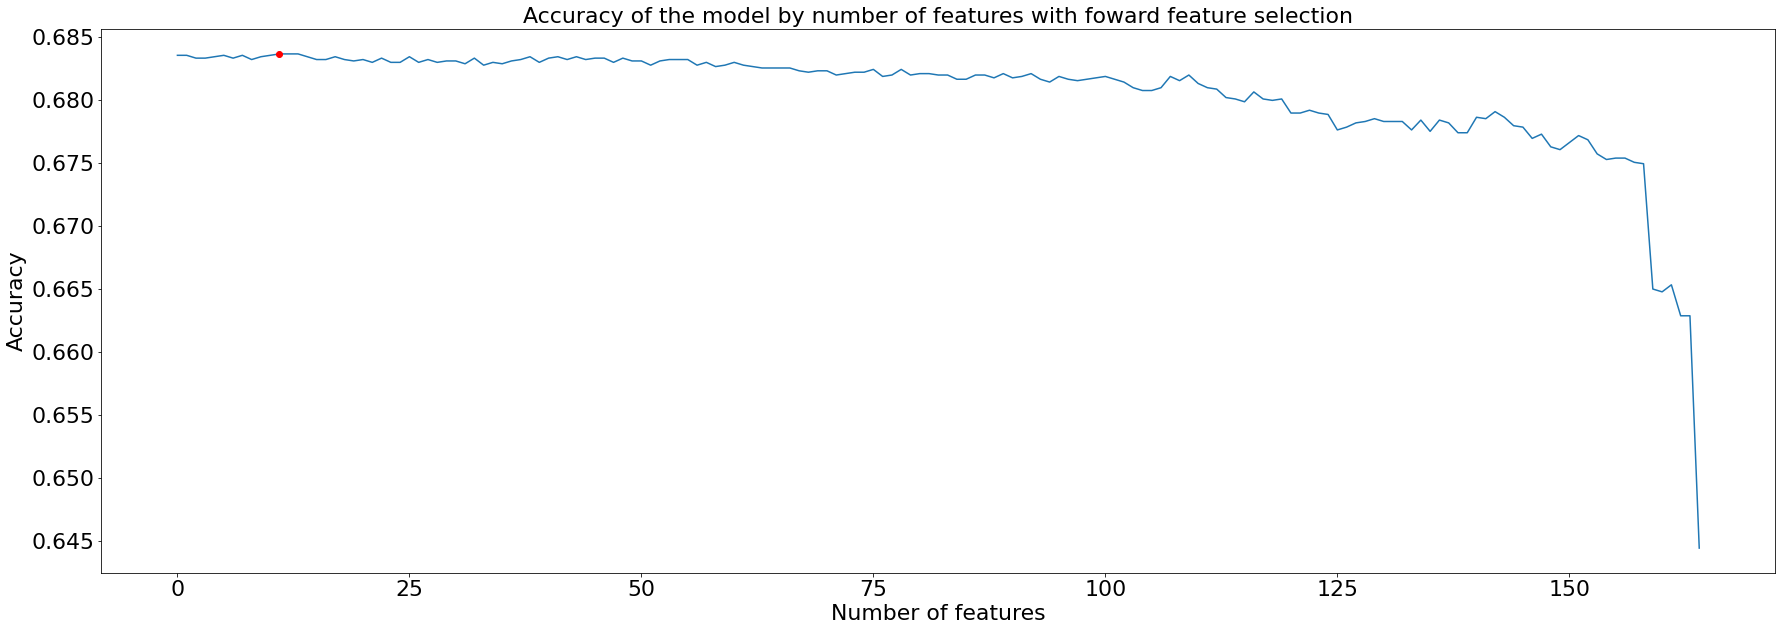

In [137]:
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.titlesize': 'medium'})

plt.plot(accuracies_for[::-1])
plt.plot(accuracies_for[::-1].index(max(accuracies_for)), max(accuracies_for), 'ro')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy of the model by number of features with foward feature selection')
plt.show()

In [138]:
#data frame for male only
#prepartion for male only models
males = cars.loc[cars['is_male'] == 1]
males.drop(['is_male'],axis=1,inplace=True)
males.reset_index(inplace=True)


c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [139]:
X_males= males.iloc[:, 1:-1]
X_males = pd.get_dummies(X_males)
y_males = males.iloc[:, -1]

In [140]:
sum(y_males)

4275

In [141]:

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_males[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_males = pd.merge(left=scaled_df,
             right=X_males.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X_males

,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,num_id,isNew,isWorkCar,isSUV,...,model_Tucson,model_V220,model_V250,model_Veloster,model_Viano,model_Vitara,model_Vito,model_X5,model_X6,model_XV
0,0.186801,0.151278,-0.632375,-0.095042,0.121045,0.379524,10008526,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.882708,-0.256366,0.644575,-0.471710,0.650384,-0.414652,10013906,1,0,1,...,1,0,0,0,0,0,0,0,0,0
2,1.256309,-0.381609,-0.417724,-0.005170,-1.085686,-0.306449,10027084,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.793582,1.004727,0.656822,0.440230,0.171350,0.696032,10028086,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.258828,-0.663278,0.656822,-0.658686,0.319404,-0.776082,10045224,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7895,-0.793582,0.303531,0.246213,-0.130760,0.542915,0.202152,99931427,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7896,0.454178,-0.164415,0.826996,-0.271675,0.007861,-0.368710,99933142,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7897,2.147566,0.677839,-0.838002,0.150384,0.362277,1.132140,99950126,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7898,-0.169702,0.553712,0.256526,0.431950,-0.388857,0.438033,99957497,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [142]:
#split the test and train set
X_train, X_test, y_train, y_test = train_test_split(X_males, y_males, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
#logistic regression for males only
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       712
           1       0.55      1.00      0.71       868

    accuracy                           0.55      1580
   macro avg       0.27      0.50      0.35      1580
weighted avg       0.30      0.55      0.39      1580



c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [143]:
#model for female only
females = cars.loc[cars['is_male'] == 0]
females.reset_index(inplace=True)
X_females= females.iloc[:, 1:-1]
X_females = pd.get_dummies(X_females)
y_females = females.iloc[:, -1]

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_females[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_females = pd.merge(left=scaled_df,
             right=X_females.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X_females

X_train, X_test, y_train, y_test = train_test_split(X_females, y_females, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93       633
           1       0.00      0.00      0.00        98

    accuracy                           0.87       731
   macro avg       0.43      0.50      0.46       731
weighted avg       0.75      0.87      0.80       731



c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [144]:
#printing females dataframe
females

,index,num_id,brand,model,age,funding_amount,fundingPercent,month_payment,payment_duration,car_price,is_male,isNew,isWorkCar,isSUV,seatsAmount,ind_sold
0,0,10006776,Mercedes,C220,59.0,45000.00,65.22,1388.44,32.41,69000.000000,0,0,0,0,5,0
1,2,10008996,Mitsubishi,L200,37.0,146069.00,81.03,3023.54,48.31,180256.512821,0,1,1,1,5,0
2,4,10021356,Hyundai,I-20,29.0,76402.79,84.82,1380.31,55.35,90078.034188,0,1,0,0,5,1
3,5,10022556,Hyundai,I-20,42.0,55897.51,59.42,1000.01,55.90,94068.008547,0,1,0,0,5,0
4,14,10107070,Mercedes,V250,62.0,218450.03,85.00,3955.23,55.23,257000.042735,0,1,1,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3650,11547,99938194,Hyundai,Tucson,31.0,136900.26,79.18,3030.22,45.18,172902.610000,0,1,0,1,5,1
3651,11549,99951971,Mitsubishi,L200,65.6,55000.00,28.21,2400.63,22.91,195000.000000,0,0,1,1,5,1
3652,11551,99958487,Mercedes,C220,47.0,127415.00,85.00,2349.21,54.24,149900.000000,0,1,0,0,5,0
3653,11552,99982187,Hyundai,I-20,40.0,75493.24,80.00,1242.15,60.78,94368.606838,0,1,0,0,5,0


In [145]:
#create new dataframe with balanced data for females
females_balanced = females.copy()
females_balanced = (females_balanced.groupby('ind_sold', as_index=False).apply(lambda x: x.sample(n=500)).reset_index(drop=True))
print(sum(females_balanced.ind_sold))
X_females= females_balanced.iloc[:, 1:-1]
X_females.drop(["brand","model","num_id","is_male"],axis=1,inplace=True)
y_females = females_balanced.iloc[:, -1]

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_females[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_females = pd.merge(left=scaled_df,
             right=X_females.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X_females
#logistic regression on X_top_selling

X_train, X_test, y_train, y_test = train_test_split(X_females, y_females, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
#logistic regression

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
probability = logreg.predict_proba(X_test)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))

500
              precision    recall  f1-score   support

           0       0.53      0.30      0.39       106
           1       0.47      0.70      0.56        94

    accuracy                           0.49       200
   macro avg       0.50      0.50      0.47       200
weighted avg       0.50      0.49      0.47       200



In [146]:
#create new dataframe with balanced data for males
males_balanced = males.copy()
males_balanced = (males_balanced.groupby('ind_sold', as_index=False).apply(lambda x: x.sample(n=2500)).reset_index(drop=True))
print(sum(males_balanced.ind_sold))
X_males= males_balanced.iloc[:, 1:-1]
X_males.drop(["brand","model","num_id"],axis=1,inplace=True)
y_males = males_balanced.iloc[:, -1]

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_males[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_males = pd.merge(left=scaled_df,
             right=X_males.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
X_males
#logistic regression on X_top_selling

X_train, X_test, y_train, y_test = train_test_split(X_males, y_males, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
#logistic regression

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
probability = logreg.predict_proba(X_test)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))

2500
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       495
           1       0.58      0.65      0.61       505

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000



In [147]:
#model for work cars only
workCars = cars.loc[cars['isWorkCar'] == 1]
workCars.reset_index(inplace=True)
workCars.drop(['isWorkCar'],axis=1,inplace=True)
X_workCars= workCars.iloc[:, 1:-1]
X_workCars = pd.get_dummies(X_workCars)
y_workCars = workCars.iloc[:, -1]

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_workCars[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_workCars = pd.merge(left=scaled_df,
             right=X_workCars.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
#logistic regression on X_top_selling

X_train, X_test, y_train, y_test = train_test_split(X_workCars, y_workCars, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
#logistic regression

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
probability = logreg.predict_proba(X_test)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.60      1.00      0.75       359
           1       0.00      0.00      0.00       235

    accuracy                           0.60       594
   macro avg       0.30      0.50      0.38       594
weighted avg       0.37      0.60      0.46       594



c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [148]:
#a logistic regression model for new cars only
isNew = cars.loc[cars['isNew'] == 1]
isNew.reset_index(inplace=True)
isNew.drop(['isNew'],axis=1,inplace=True)
X_isNew= isNew.iloc[:, 1:-1]
X_isNew = pd.get_dummies(X_isNew)
y_isNew = isNew.iloc[:, -1]

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_isNew[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_isNew = pd.merge(left=scaled_df,
             right=X_isNew.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
#logistic regression on X_top_selling

X_train, X_test, y_train, y_test = train_test_split(X_isNew, y_isNew, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
#logistic regression

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))


c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1118
           1       0.00      0.00      0.00       865

    accuracy                           0.56      1983
   macro avg       0.28      0.50      0.36      1983
weighted avg       0.32      0.56      0.41      1983



c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:
#a model for used cars only
used = cars.loc[cars['isNew'] == 0]
used.reset_index(inplace=True)
used.drop(['isNew'],axis=1,inplace=True)
X_isNew= isNew.iloc[:, 1:-1]
X_isNew = pd.get_dummies(X_isNew)
y_isNew = isNew.iloc[:, -1]

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_isNew[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_isNew = pd.merge(left=scaled_df,
             right=X_isNew.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)
#logistic regression on X_top_selling

X_train, X_test, y_train, y_test = train_test_split(X_isNew, y_isNew, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
#logistic regression

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))

c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1118
           1       0.00      0.00      0.00       865

    accuracy                           0.56      1983
   macro avg       0.28      0.50      0.36      1983
weighted avg       0.32      0.56      0.41      1983



c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [150]:
#a logistic regression model without isMale feature
cars = pd.read_excel('cars.xlsx')
data_without_gender = cars.copy()

y_data_without_gender = data_without_gender.ind_sold
data_without_gender.drop(["is_male","ind_sold"],axis=1,inplace=True)
X_data_without_gender= data_without_gender.iloc[:, 1:]
X_data_without_gender = pd.get_dummies(data_without_gender)

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_data_without_gender[['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price']]),
                         columns=['age', 'funding_amount', 'fundingPercent', 'month_payment', 'payment_duration', 'car_price'])

X_data_without_gender = pd.merge(left=scaled_df,
             right=X_data_without_gender.drop(['age', 'funding_amount', 'fundingPercent',
                          'month_payment', 'payment_duration', 'car_price'], axis=1),
             left_index=True, right_index=True)

X_train, X_test, y_train, y_test = train_test_split(X_data_without_gender, y_data_without_gender, test_size=0.2, random_state=1337)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)


logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1338
           1       0.00      0.00      0.00       973

    accuracy                           0.58      2311
   macro avg       0.29      0.50      0.37      2311
weighted avg       0.34      0.58      0.42      2311



c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo